In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
from matplotlib import colors as c 
# import verde as vd
from scipy.interpolate import RegularGridInterpolator
import geopandas as gpd
from shapely.geometry import mapping, Polygon, Point
from shapely.ops import unary_union

import processing as arp

In [17]:
region

,grdc_no,river,station,area,altitude,lat_org,long_org,lat_pp,long_pp,dist_km,area_calc,quality,type,comment,source,geometry
0,4115080.0,COWLITZ RIVER,"CASTLE ROCK, WA",5796.4,6.16,46.2748,-122.9146,46.2771,-122.9146,0.3,5776.5,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((-121.57080 46.87500, -121.56670 46.8..."
1,4115081.0,COWLITZ RIVER,"BELOW MAYFIELD DAM, WA",3626.0,69.07,46.5104,-122.6162,46.5104,-122.6146,0.1,3590.9,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((-121.57080 46.87500, -121.56670 46.8..."
2,4115082.0,COWLITZ RIVER,"PACKWOOD, WA",743.3,319.43,46.6129,-121.6793,46.6146,-121.6771,0.3,813.4,Medium,Automatic,Area difference 5-10% and distance <= 5 km,hydrosheds,"POLYGON ((-121.57080 46.87500, -121.56670 46.8..."
3,4115100.0,WILLAMETTE RIVER,"SALEM, OR",18855.2,32.35,44.9443,-123.0429,44.9438,-123.0438,0.1,18845.7,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((-123.16670 45.00830, -123.16250 45.0..."
4,4115101.0,WILLAMETTE RIVER,"PORTLAND, OR",29008.0,0.47,45.5185,-122.6679,45.5187,-122.6688,0.1,28902.7,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((-123.08750 45.79580, -123.04580 45.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,4215706.0,KOOTENAI RIVER,FORT STEELE,11400.0,-999.00,49.6119,-115.6344,49.6104,-115.6312,0.3,11531.8,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((-116.29170 51.33330, -116.28330 51.3..."
121,4215710.0,ELK RIVER,FERNIE,3110.0,-999.00,49.5100,-115.0714,49.5104,-115.0687,0.2,3085.2,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"MULTIPOLYGON (((-115.01670 49.68330, -115.0125..."
122,4215750.0,KOOTENAI RIVER,KOOTENAY CROSSING,420.0,1200.00,50.8861,-116.0430,50.8854,-116.0479,0.4,511.3,Low,Automatic,Area difference 10-50% and distance <= 5 km,hydrosheds,"POLYGON ((-116.36250 51.20420, -116.34170 51.2..."
123,4215800.0,GRAVE CREEK,AT THE MOUTH,84.0,1260.00,49.8433,-114.8600,49.8438,-114.8604,0.1,86.8,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((-114.82500 49.88750, -114.82080 49.8..."


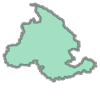

In [2]:
grdc = xr.open_dataset(
    '/home/Marc.Prange/work/2024-04-03_20-55/GRDC-Daily.nc'
    )
grdc_dsch = (grdc.runoff_mean * 1000 / grdc.area / 1e6).mean('id')

region = gpd.read_file('/home/Marc.Prange/work/2024-04-03_20-55/stationbasins.geojson')
# region = region.loc[region['river'] == 'SAN JOAQUIN RIVER']
region_cmb_geometry = unary_union([region.loc[i].geometry for i in range(len(region))])
region_cmb_geometry

In [44]:
model_data = xr.open_dataset(
        '/archive/Marc.Prange/na_data/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/'
        'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020_na_1991.nc').load()
model_gauge_dsch = [model_data.rv_o_h2o.interp(lat=lat, lon=lon, method='linear') 
                  for lat, lon in zip(region.lat_org, region.long_org)]
model_gauge_dsch

[<xarray.DataArray 'rv_o_h2o' (time: 365)>
 array([0.00076008, 0.00075386, 0.00074682, 0.00073923, 0.00073176,
        0.00072575, 0.00076024, 0.00078358, 0.00082072, 0.00083841,
        0.00094264, 0.00124971, 0.00130257, 0.00131098, 0.00127646,
        0.0012319 , 0.00120687, 0.00120195, 0.00121428, 0.00123892,
        0.0012701 , 0.00130228, 0.00133092, 0.00135279, 0.00136599,
        0.00136991, 0.00136492, 0.00135226, 0.00133322, 0.00130887,
        0.00128157, 0.00125396, 0.00123913, 0.00123504, 0.00129194,
        0.00129283, 0.00125629, 0.00122293, 0.00119437, 0.00117151,
        0.0011552 , 0.00114515, 0.00114439, 0.00117876, 0.00119382,
        0.00119683, 0.00119848, 0.00120756, 0.00124505, 0.00128233,
        0.00140733, 0.00138732, 0.00135837, 0.00133326, 0.00131408,
        0.00130126, 0.00129418, 0.00129187, 0.00129303, 0.0012973 ,
        0.00131098, 0.00135706, 0.00140477, 0.00140467, 0.0014092 ,
        0.00139497, 0.00137648, 0.00135563, 0.00134491, 0.00132904,
     

In [60]:
xr.DataArray(
    model_gauge_dsch, 
    coords={'gauge_number': np.arange(len(model_gauge_dsch)), 'time': model_data.time})

<xarray.DataArray (gauge_number: 125, time: 365)>
array([[7.60076405e-04, 7.53859684e-04, 7.46819826e-04, ...,
        6.81499749e-04, 6.80090354e-04, 6.78075401e-04],
       [3.40893691e-04, 3.37183620e-04, 3.32295129e-04, ...,
        2.93655511e-04, 2.92709550e-04, 2.91518393e-04],
       [1.29932094e-04, 1.28906011e-04, 1.27525546e-04, ...,
        1.20155598e-04, 1.19637012e-04, 1.19024012e-04],
       ...,
       [1.59726681e-05, 1.58559936e-05, 1.57399936e-05, ...,
        1.65709116e-05, 1.64857452e-05, 1.64016017e-05],
       [1.96313896e-06, 1.94649368e-06, 1.93015557e-06, ...,
        2.16779003e-06, 2.14335249e-06, 2.12006347e-06],
       [1.29737112e-06, 1.28487692e-06, 1.27321315e-06, ...,
        1.62156411e-06, 1.57109838e-06, 1.52521779e-06]])
Coordinates:
  * gauge_number  (gauge_number) int64 0 1 2 3 4 5 6 ... 119 120 121 122 123 124
  * time          (time) datetime64[ns] 1991-01-01 1991-01-02 ... 1991-12-31

In [12]:
model_basin_mask = xr.DataArray(
    data=np.array([[region_cmb_geometry.contains(Point(lon, lat)) 
                    for lon in model_data.lon] 
                   for lat in model_data.lat]).squeeze(),
    coords=(model_data.lat, model_data.lon)
    )

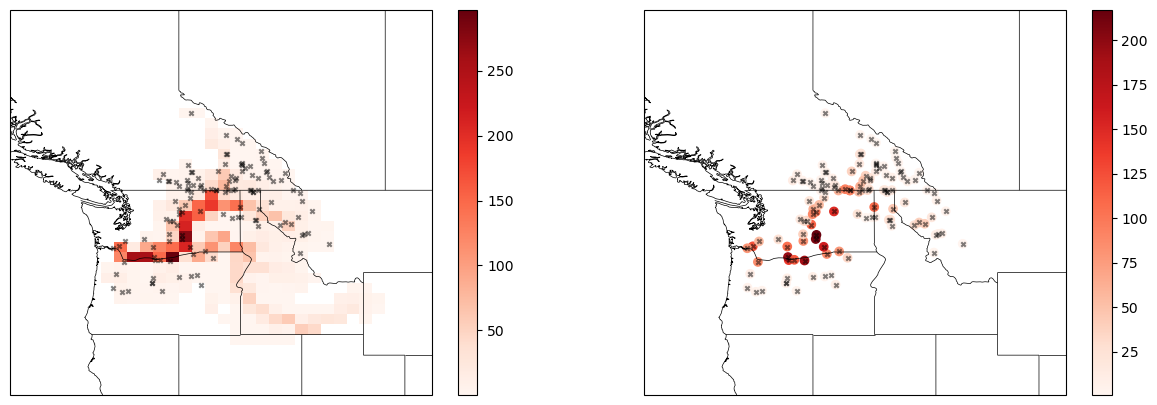

In [53]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
pc = ax1.pcolormesh(
    model_data.lon, model_data.lat, 
    model_data.isel(time=100).where(model_basin_mask).rv_o_h2o*86400,
    cmap='Reds'
    )
fig.colorbar(pc)
ax1.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
s = ax2.scatter(
    [d.lon for d in model_gauge_dsch], [d.lat for d in model_gauge_dsch],
    c=[d.isel(time=100)*86400 for d in model_gauge_dsch],
    cmap='Reds'
    )
ax2.scatter(region.long_org, region.lat_org, marker='x', color='black', s=10, alpha=0.5)
fig.colorbar(s)
for ax in [ax1, ax2]:
    ax.set_extent([region.long_org.min()-5, region.long_org.max()+5, region.lat_org.min()-5, region.lat_org.max()+5], crs=ccrs.PlateCarree())
    ax.coastlines("10m", linewidth=0.5)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    # axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

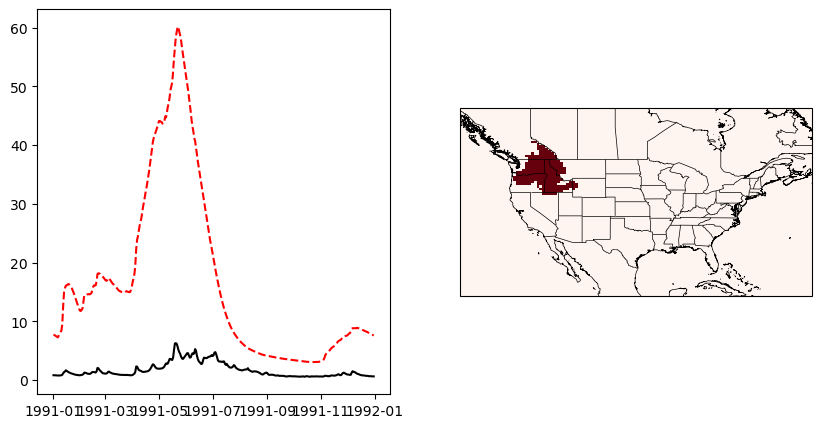

In [63]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)

model_dsch = model_data.rv_o_h2o.where(model_basin_mask).mean(['lat', 'lon'])
model_time_mask = np.isin(model_dsch.time, grdc_dsch.time)
obs_time_mask = np.isin(grdc_dsch.time, model_dsch.time)
obs_dsch = grdc_dsch.isel(time=obs_time_mask)
model_dsch = model_dsch.isel(time=model_time_mask)
ax1.plot(
    obs_dsch.time.isel(time=np.arange(0, 365)), 
    obs_dsch.isel(time=np.arange(0, 365))*86400, 
    color='black')
ax1.plot(
    model_data.time.isel(time=np.arange(0, 365)), 
    model_dsch.isel(time=np.arange(0, 365))*86400,
    color='red', ls='--')
ax1.plot(
    model_gauge_dsch[0].time.isel(time=np.arange(0, 365)), 
    model_dsch.isel(time=np.arange(0, 365))*86400,
    color='red', ls='--')
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
pc = ax2.pcolormesh(
    model_data.lon, model_data.lat, 
    model_basin_mask,
    cmap='Reds'
    )


# ax1.legend()
# ax1.set(xlim=[])
for ax in [ax2]:
    ax.set_extent([-135, -60, 20, 60], crs=ccrs.PlateCarree())
    ax.coastlines("10m", linewidth=0.5)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    # axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)